# Micro-narrative analysis of _The Lord of the Rings_

In [3]:
import glob
import os.path

docs = []
for file in glob.glob("input/*.txt"):
    with open(file) as f:
        text = f.read()
        sections = text.split("\n")
        for section in sections:
            section = section.strip()
            if section:
                docs.append(section)

In [2]:
from narrativegraph import NarrativeGraph
from narrativegraph.nlp.extraction.spacy import NaiveSpacyTripletExtractor

if os.path.exists("lotr.sqlite"):
    model = NarrativeGraph.load("lotr.sqlite")
else:
    model = NarrativeGraph(
        triplet_extractor=NaiveSpacyTripletExtractor(
            named_entities=(1, None),
            noun_chunks=(2, None),
        ),
        sqlite_db_path="lotr.sqlite"
    ).fit(docs)

INFO:narrativegraph.pipeline:Adding 9240 documents to database
INFO:narrativegraph.pipeline:Extracting triplets
Extracting triplets: 100%|██████████| 9240/9240 [00:52<00:00, 177.20it/s]
INFO:narrativegraph.pipeline:Mapping entities and predicates
INFO:narrativegraph.pipeline:Mapping triplets


In [4]:
coocs = model.co_occurrences_
coocs[coocs.frequency > 1]

,id,entity_one,entity_one_frequency,entity_two,entity_two_frequency,frequency,doc_frequency,adjusted_tf_idf,pmi,entity_one_id,entity_two_id
0,1,The Dark Lord,26,his dark throne,4,2,2,277.0,2.501165,6680,1662
1,2,his dark throne,4,the Land of Mordor,4,2,2,277.0,3.314078,1662,1527
4,5,Moria,38,Gandalf,261,4,4,498.6,0.822804,5709,5545
8,9,BALIN,9,Moria,38,3,3,415.5,2.160263,419,5709
37,38,Bilbo,143,Hobbits,36,2,2,277.0,0.806559,6345,308
...,...,...,...,...,...,...,...,...,...,...,...
7242,7243,Cottons,11,Rosie,9,2,1,415.5,2.522563,3744,1526
7243,7244,Rosie,9,Sam,406,2,2,277.0,0.955429,1526,3881
7291,7292,Gamgee,4,Frodo,607,2,1,415.5,1.132949,981,1282
7338,7339,Lotho,9,Merry,150,2,1,415.5,1.387864,2961,3748


Below, we show in a plot that low-frequency entity pairs tend to have a higher PMI.

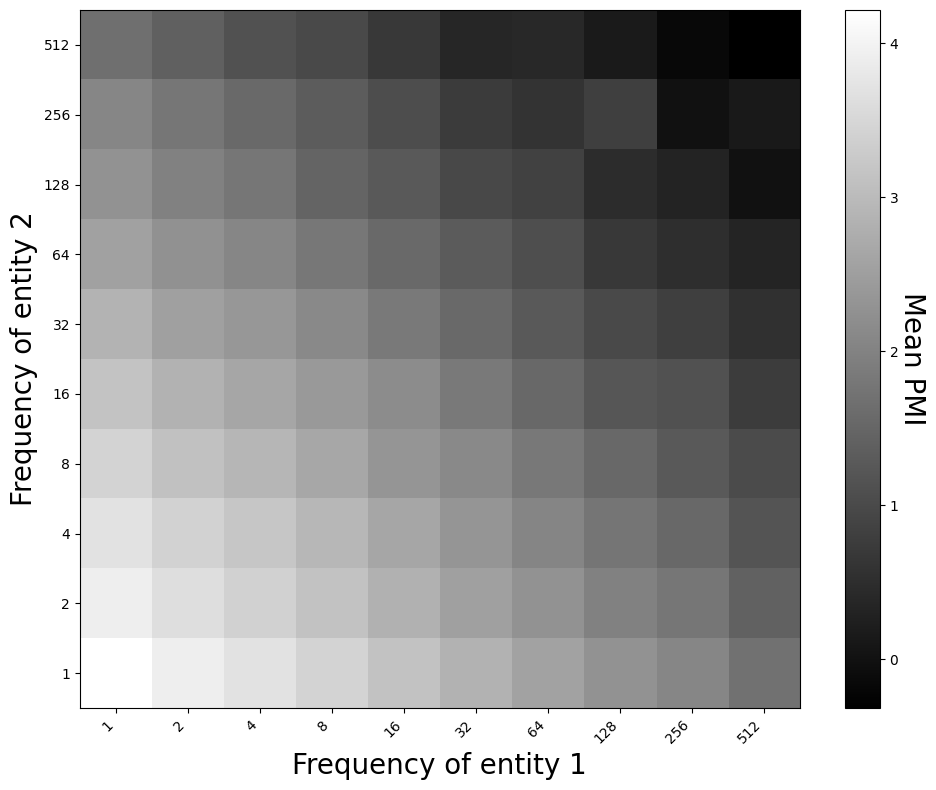

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create frequency bins
max_freq = max(coocs['entity_one_frequency'].max(), coocs['entity_two_frequency'].max())
freq_bins = [0] + [2**i for i in range(0, int(np.log2(max_freq)) + 1)]

df = pd.DataFrame()

# Bin the data
df['x_bin'] = pd.cut(coocs.entity_one_frequency, bins=freq_bins)
df['y_bin'] = pd.cut(coocs.entity_two_frequency, bins=freq_bins)
df['pmi'] = coocs.pmi

# Calculate mean PMI for each cell
heatmap_data = df.groupby(['x_bin', 'y_bin'], observed=True)['pmi'].mean().unstack()

# Create labels from bin edges
def format_bin_label(val):
    if val < 1000:
        return str(int(val))
    else:
        return f"{int(val/1000)}k"

bin_labels = [format_bin_label(b) for b in freq_bins[1:]]  # skip 0

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(heatmap_data, cmap='grey', aspect='auto', origin='lower')

# Labels
ax.set_xlabel('Frequency of entity 1', fontsize=20)
ax.set_ylabel('Frequency of entity 2', fontsize=20)
ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_yticks(range(len(heatmap_data.index)))
ax.set_xticklabels(bin_labels, rotation=45, ha='right')
ax.set_yticklabels(bin_labels)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Mean PMI', rotation=270, labelpad=20, fontsize=20)

plt.tight_layout()
plt.show()

In [6]:
model.entities_

,id,label,frequency,doc_frequency,adjusted_tf_idf,alt_labels
0,1,a marvellous year,1,1,0.0,"[""a marvellous year""]"
1,2,black silent shapes,1,1,0.0,"[""black silent shapes""]"
2,3,their smooth sides,1,1,0.0,"[""their smooth sides""]"
3,4,its cold silver,1,1,0.0,"[""its cold silver""]"
4,5,Men,3,2,554.0,"[""Men"",""Tall Men""]"
...,...,...,...,...,...,...
7340,7341,the lighted inn,1,1,0.0,"[""the lighted inn""]"
7341,7342,'The New Age,2,1,415.5,"[""'The New Age""]"
7342,7343,a noisome smell,1,1,0.0,"[""a noisome smell""]"
7343,7344,a great shout,1,1,0.0,"[""a great shout""]"


In [ ]:
# create server to be viewed in own browser which blocks execution of other cells
model.serve_visualizer()

INFO:     Started server process [20733]
INFO:     Waiting for application startup.
INFO:root:Database engine provided to state before startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8001 (Press CTRL+C to quit)
